Data Ingestion:Data is loaded using Apache Spark, which handles large datasets and prepares them for cleaning and analysis

In [46]:
import re
from textblob import TextBlob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
import pandas as pd

In [2]:
spark = SparkSession.builder \
    .appName("FeedbackProcessing") \
    .getOrCreate()

In [12]:
feedback_df = spark.read.csv(
    "/feedback_analysis.csv",
    header=True,
    inferSchema=True
)

In [13]:
feedback_df.show(5)

+----------+---------------+------+--------------------+----------+
|CustomerID|FeedbackChannel|Rating|             Comment|      Date|
+----------+---------------+------+--------------------+----------+
|    C00001|          Email|     4|      Great service!|01-11-2024|
|    C00002|   Social Media|     2|Could improve pro...|02-11-2024|
|    C00003|         Survey|     5|Excellent experie...|03-11-2024|
|    C00004|          Email|     3|     Average service|04-11-2024|
|    C00005|   Social Media|     1|Very disappointed...|05-11-2024|
+----------+---------------+------+--------------------+----------+
only showing top 5 rows



Data Cleaning: Text data is cleaned by removing unnecessary characters, correcting misspellings, and converting to lowercase to standardize for further analysis.

In [8]:
def clean_comment(comment):
    if comment:
        comment = comment.lower()
        comment = re.sub(r'[^a-zA-Z\s]', '', comment)
        comment = ' '.join([TextBlob(word).correct().string for word in comment.split()])
    return comment

clean_comment_udf = udf(clean_comment, StringType())

In [14]:
cleaned_feedback_df = feedback_df.withColumn("CleanedComment", clean_comment_udf(col("Comment")))

Sentiment Analysis:Each feedback comment is analyzed for sentiment (positive, neutral, or negative) using TextBlob’s sentiment analysis capabilities.





In [15]:
def analyze_sentiment(comment):
    if comment:
        analysis = TextBlob(comment)
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
    return 'neutral'

analyze_sentiment_udf = udf(analyze_sentiment, StringType())

In [16]:
sentiment_feedback_df = cleaned_feedback_df.withColumn("Sentiment", analyze_sentiment_udf(col("CleanedComment")))

Trend Analysis:Grouping by date and sentiment gives insights into how sentiments vary over time. Grouping by feedback channels allows a comparison of sentiment distribution across channels

In [17]:
trends_df = sentiment_feedback_df.groupBy("Date", "Sentiment").count()



In [18]:
channel_sentiment_df = sentiment_feedback_df.groupBy("FeedbackChannel", "Sentiment").count()

In [19]:
avg_rating_df = sentiment_feedback_df.groupBy("FeedbackChannel").agg(F.avg("Rating").alias("AverageRating"))

In [20]:
trends_pd_df = trends_df.toPandas()
channel_sentiment_pd_df = channel_sentiment_df.toPandas()
avg_rating_pd_df = avg_rating_df.toPandas()

Data Visualization

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

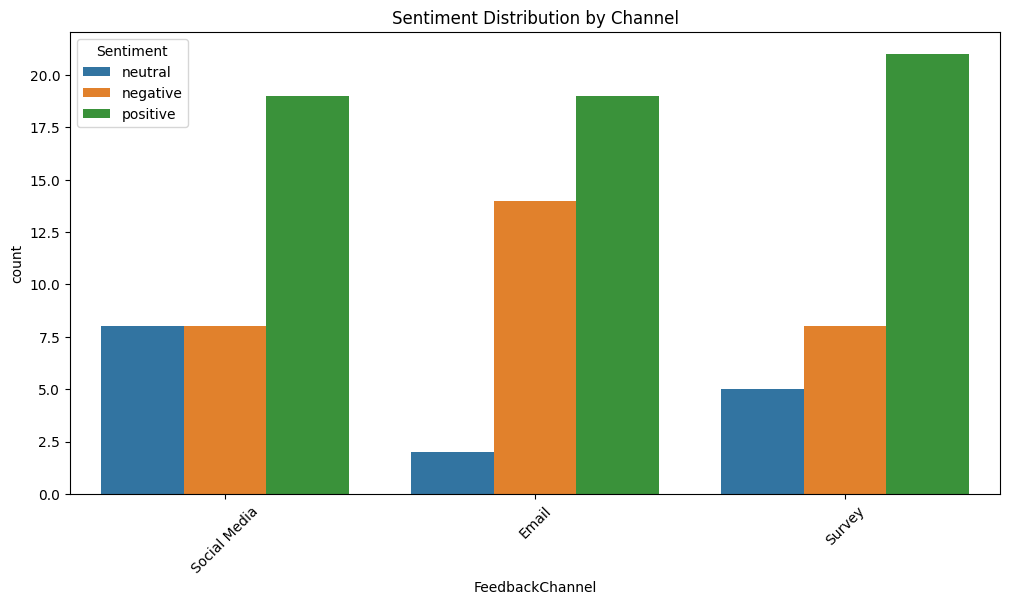

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(data=channel_sentiment_pd_df, x='FeedbackChannel', y='count', hue='Sentiment')
plt.title('Sentiment Distribution by Channel')
plt.xticks(rotation=45)
plt.show()

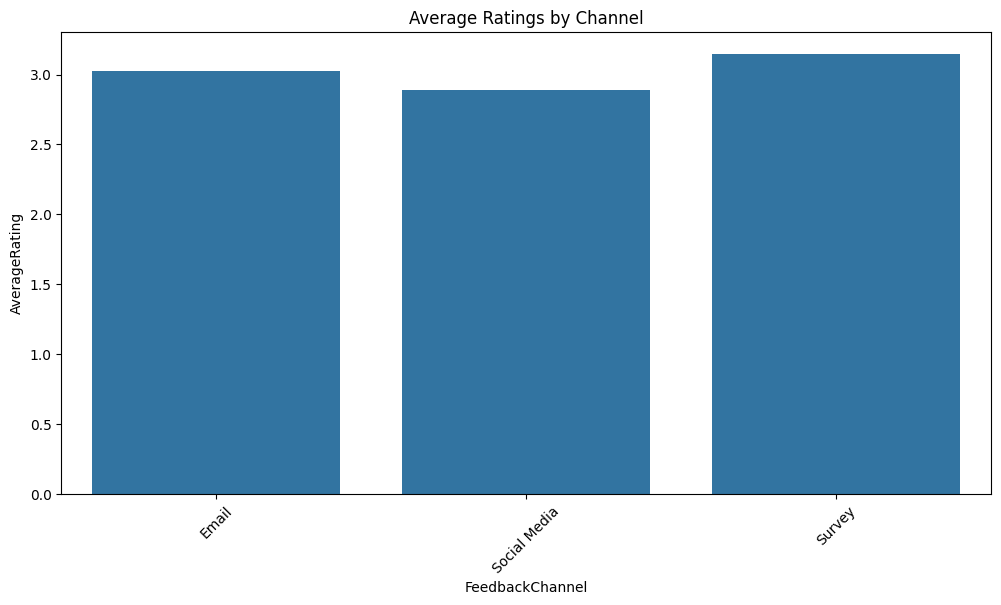

In [26]:
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_rating_pd_df, x='FeedbackChannel', y='AverageRating')
plt.title('Average Ratings by Channel')
plt.xticks(rotation=45)
plt.show()

<ipython-input-34-7d38f7f2907d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sentiment_feedback_df.toPandas(), x="FeedbackChannel", y="Rating", palette="Set3")


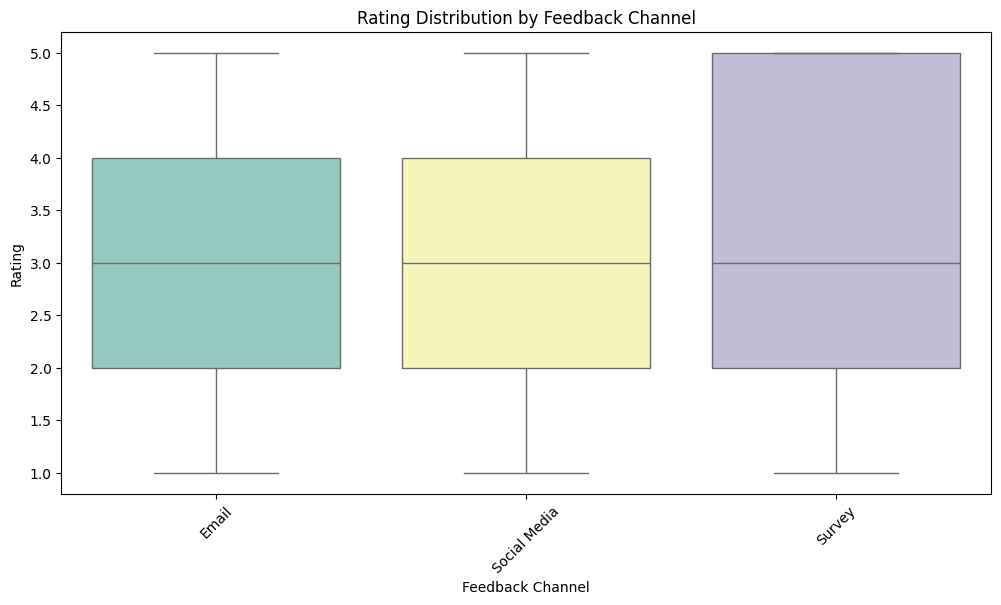

In [34]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=sentiment_feedback_df.toPandas(), x="FeedbackChannel", y="Rating", palette="Set3")
plt.title("Rating Distribution by Feedback Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.show()


<ipython-input-41-257785aed182>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_sentiment_score_pd_df, x="FeedbackChannel", y="AvgSentimentScore", palette="coolwarm")


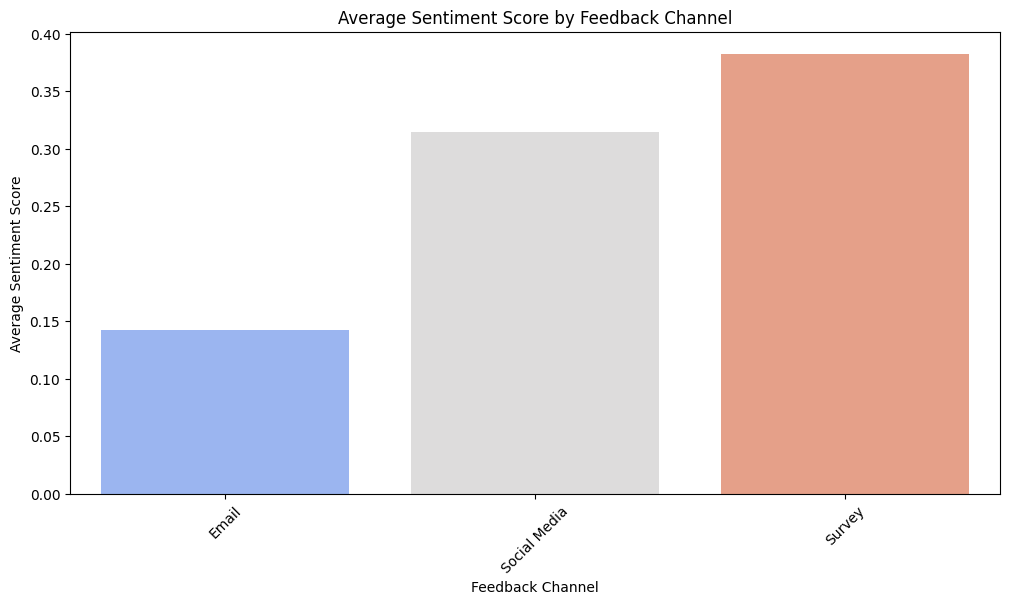

In [41]:
# Assign sentiment scores and calculate average
sentiment_score_df = sentiment_feedback_df.withColumn(
    "SentimentScore",
    F.when(col("Sentiment") == "positive", 1)
     .when(col("Sentiment") == "negative", -1)
     .otherwise(0)
)

avg_sentiment_score_df = sentiment_score_df.groupBy("FeedbackChannel").agg(F.avg("SentimentScore").alias("AvgSentimentScore"))
avg_sentiment_score_pd_df = avg_sentiment_score_df.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_sentiment_score_pd_df, x="FeedbackChannel", y="AvgSentimentScore", palette="coolwarm")
plt.title("Average Sentiment Score by Feedback Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.show()
